# Diffusion models

Synthetid 2-D data

2024-2-10

Author: Yung-Kyun Noh, Ph.D.

Hanyang University / Korea Institute for Advanced Study

2024 Machine Learning Algorithms

This notebook implements simple diffusion models using synthetic 2-dimensional set. 

The codes are based on the functions modified from the following example, 

https://colab.research.google.com/drive/1AZ2_BAwXrU8InE_qAE9cFZ0lsIO5a_xp?usp=sharing,

which has been explained in 

https://medium.com/mlearning-ai/enerating-images-with-ddpms-a-pytorch-implementation-cef5a2ba8cb1.

Partly, sample hands-on codes in the following NVIDIA DLI program is used.

https://www.nvidia.com/en-us/training/instructor-led-workshops/generative-ai-with-diffusion-models/.


In [1]:
import random
import numpy as np
import glob
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

# Visualization tools
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
from torchvision.utils import save_image, make_grid

import math

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [2]:
!nvidia-smi

Tue Feb 13 19:54:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX               Off | 00000000:01:00.0 Off |                  N/A |
| 41%   31C    P8               3W / 280W |     94MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Getting device
run_gpu = 0    # 0,1,2,3,...
dev = 'cuda:' + str(run_gpu)
# dev='cpu'

print(torch.cuda.is_available())
device = torch.device(dev if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

True
Using device: cuda:0	NVIDIA TITAN RTX


In [4]:
def draw_data(data_0, data_1, title_str='Data'):
    # function for scattering data
    
    # create a figure and axis
    fig, ax = plt.subplots()

    # Scatter data points in 2-dimensional space
    ax.scatter(data_0[:,0], data_0[:,1], label='class 0', c='red', alpha=.3)
    ax.scatter(data_1[:,0], data_1[:,1], label='class 1', marker='^', c='blue', alpha=.3)
    # set a title and labels
    ax.set_title(title_str)
    ax.legend()


In [5]:
# generate two Gaussians (class 1 & class 2)
dim = 2
datanum_0 = 200
datanum_1 = 200
mean_0 = np.array([-.1, .1])
mean_1 = np.array([.1, -.1])
cov_0 = np.array([[.1,.02],[.02,.1]])
cov_1 = np.array([[.1,.09],[.09,.1]])
# float32
L = torch.linalg.cholesky(torch.from_numpy(cov_0).to(dev)).to(torch.float32)
data_0 = torch.matmul(torch.randn(datanum_0, dim, device=dev, dtype=torch.float32), L.T) \
        + torch.from_numpy(mean_0).to(torch.float32).to(dev)
L = torch.linalg.cholesky(torch.from_numpy(cov_1).to(dev)).to(torch.float32)
data_1 = torch.matmul(torch.randn(datanum_1, dim, device=dev, dtype=torch.float32), L.T) \
        + torch.from_numpy(mean_1).to(torch.float32).to(dev)

# data_0 = np.random.multivariate_normal(mean_0, cov_0, datanum_0)
# data_1 = np.random.multivariate_normal(mean_1, cov_1, datanum_1)

n_classes = 2
data = torch.cat([data_0, data_1])
datanums = [len(data_0), len(data_1)]
labels = torch.cat([torch.zeros(datanums[0]), torch.ones(datanums[1])])


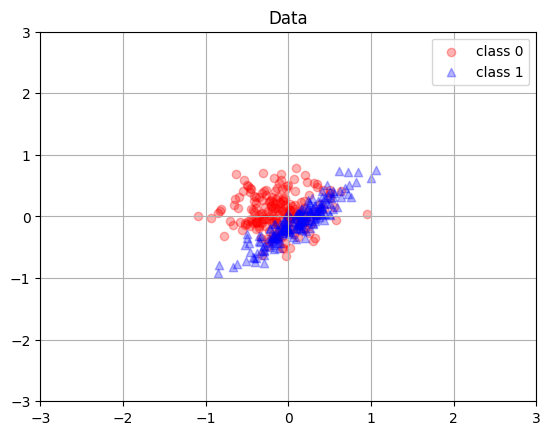

In [6]:
draw_data(data_0.cpu(), data_1.cpu(), title_str='Data')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)

In [7]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)
    
    def backward_cfg(self, x, t, c, c_mask):   # Classifier-free guidance
        return self.network(x, t, c, c_mask)

In [8]:
# Diffuse data
T_col = 8
T_row = 10
T = T_col*T_row
B_start = 0.0001
B_end = 0.02


In [9]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
#             nn.Unflatten(1, (emb_dim, 1, 1)),
            nn.Unflatten(1, (emb_dim,))  # Noh, corrected
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [10]:
class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [11]:
class epsilon_diffuse(nn.Module): # all the dependencies from torch will be given to this class [parent class] # nn.Module contains all the building block of neural networks:
  def __init__(self, input_dim, output_dim, T, ns_layer=[10,5,3], t_embed_dim=8, c_embed_dim=3):
    super(epsilon_diffuse,self).__init__()  # building connection with parent and child classes
    self.T = T
    self.fc1=nn.Linear(input_dim, ns_layer[0], bias=True)       # hidden layer 1
    self.fc2=nn.Linear(ns_layer[0], ns_layer[1], bias=True)     # hidden layer 2
    self.fc3=nn.Linear(ns_layer[1], ns_layer[2], bias=True)     # hidden layer 3
    self.fc4=nn.Linear(ns_layer[2], output_dim)          # last layer

    self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
    self.t_emb1 = EmbedBlock(t_embed_dim, ns_layer[0])
    self.t_emb2 = EmbedBlock(t_embed_dim, ns_layer[1])
    self.c_embed1 = EmbedBlock(c_embed_dim, ns_layer[0])  # dim n_classes -> dim layer
    self.c_embed2 = EmbedBlock(c_embed_dim, ns_layer[1])  # dim n_classes -> dim layer

  def forward(self, x, t, c, c_mask):
    t = t.float() / self.T  # Convert from [0, T] to [0, 1]
    t = self.sinusoidaltime(t)
    t_emb1 = self.t_emb1(t)
    t_emb2 = self.t_emb2(t)

    c = c*c_mask
    c_emb1 = self.c_embed1(c)
    c_emb2 = self.c_embed2(c)

    out=torch.relu(self.fc1(x))              # input * weights + bias for layer 1
    out=torch.relu(self.fc2(c_emb1*out + t_emb1))            # input * weights + bias for layer 2
    out=torch.relu(self.fc3(c_emb2*out + t_emb2))            # input * weights + bias for layer 3
    out=self.fc4(out)                        # input * weights + bias for last layer
    return out                               # final outcome


### Initiating the model

In [12]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, d = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, d).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)
    
    def backward_cfg(self, x, t, c, c_mask):   # Classifier-free guidance
        return self.network(x, t, c, c_mask)

In [13]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
input_dim=2
output_dim=2

ddpm = MyDDPM(epsilon_diffuse(input_dim, output_dim, T, ns_layer=[50,50,3], c_embed_dim=2), \
              n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)


In [14]:
sum([p.numel() for p in ddpm.parameters()])

14261

## Training

In [15]:
def get_context_mask(c, drop_prob, n_classes=2, device='cpu'):
    c_hot = F.one_hot(c.to(torch.int64), num_classes=n_classes).to(device)
    c_mask = torch.bernoulli(torch.ones_like(c_hot).float() - drop_prob).to(device)
    return c_hot, c_mask

In [16]:
def training_loop_cfg(ddpm, data, labels, n_epochs, optim, device, n_classes=10, c_drop_prob=0.1, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        x0 = data
        n = len(x0)
        c_hot, c_mask = get_context_mask(labels, c_drop_prob, n_classes=n_classes, device=device)  # New

        # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
        eta = torch.randn_like(x0).to(device)
        t = torch.randint(0, n_steps, (n,)).to(device)

        # Computing the noisy image based on x0 and the time-step (forward process)
        noisy_imgs = ddpm(x0, t, eta)

        # Getting model estimation of noise based on the images and the time-step
        eta_theta = ddpm.backward_cfg(noisy_imgs, t.reshape(n, -1), c_hot, c_mask)

        # Optimizing the MSE between the noise plugged and the predicted noise
        loss = mse(eta_theta, eta)
        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_loss += loss.item() * len(x0) / len(data)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [17]:
n_classes = 2
# n_epochs = 20
n_epochs = 1000
lr = 0.001

# Training
store_path = "ddpm_2d_cfg.pt"
training_loop_cfg(ddpm, data, labels, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, \
                  n_classes=n_classes, store_path=store_path)

Training progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Loss at epoch 1: 0.963 --> Best model ever (stored)
Loss at epoch 2: 1.047
Loss at epoch 3: 1.059
Loss at epoch 4: 1.106
Loss at epoch 5: 1.028
Loss at epoch 6: 1.180
Loss at epoch 7: 1.165
Loss at epoch 8: 1.065
Loss at epoch 9: 0.968
Loss at epoch 10: 1.004
Loss at epoch 11: 0.990
Loss at epoch 12: 1.108
Loss at epoch 13: 1.137
Loss at epoch 14: 0.969
Loss at epoch 15: 1.155
Loss at epoch 16: 1.177
Loss at epoch 17: 1.121
Loss at epoch 18: 1.032
Loss at epoch 19: 1.086
Loss at epoch 20: 1.046
Loss at epoch 21: 1.049
Loss at epoch 22: 0.933 --> Best model ever (stored)
Loss at epoch 23: 1.097
Loss at epoch 24: 1.154
Loss at epoch 25: 1.003
Loss at epoch 26: 1.012
Loss at epoch 27: 1.077
Loss at epoch 28: 1.003
Loss at epoch 29: 1.004
Loss at epoch 30: 0.952
Loss at epoch 31: 0.915 --> Best model ever (stored)
Loss at epoch 32: 0.916
Loss at epoch 33: 0.960
Loss at epoch 34: 0.841 --> Best model ever (stored)
Loss at epoch 35: 0.971
Loss at epoch 36: 1.019
Loss at epoch 37: 0.876
Loss 

Loss at epoch 343: 0.104
Loss at epoch 344: 0.123
Loss at epoch 345: 0.144
Loss at epoch 346: 0.156
Loss at epoch 347: 0.168
Loss at epoch 348: 0.114
Loss at epoch 349: 0.114
Loss at epoch 350: 0.131
Loss at epoch 351: 0.131
Loss at epoch 352: 0.111
Loss at epoch 353: 0.126
Loss at epoch 354: 0.136
Loss at epoch 355: 0.130
Loss at epoch 356: 0.148
Loss at epoch 357: 0.153
Loss at epoch 358: 0.122
Loss at epoch 359: 0.120
Loss at epoch 360: 0.134
Loss at epoch 361: 0.119
Loss at epoch 362: 0.130
Loss at epoch 363: 0.144
Loss at epoch 364: 0.129
Loss at epoch 365: 0.135
Loss at epoch 366: 0.131
Loss at epoch 367: 0.100
Loss at epoch 368: 0.106
Loss at epoch 369: 0.148
Loss at epoch 370: 0.138
Loss at epoch 371: 0.125
Loss at epoch 372: 0.175
Loss at epoch 373: 0.106
Loss at epoch 374: 0.137
Loss at epoch 375: 0.133
Loss at epoch 376: 0.131
Loss at epoch 377: 0.118
Loss at epoch 378: 0.112
Loss at epoch 379: 0.142
Loss at epoch 380: 0.170
Loss at epoch 381: 0.127
Loss at epoch 382: 0.145


Loss at epoch 698: 0.112
Loss at epoch 699: 0.114
Loss at epoch 700: 0.133
Loss at epoch 701: 0.140
Loss at epoch 702: 0.120
Loss at epoch 703: 0.117
Loss at epoch 704: 0.127
Loss at epoch 705: 0.106
Loss at epoch 706: 0.103
Loss at epoch 707: 0.153
Loss at epoch 708: 0.113
Loss at epoch 709: 0.182
Loss at epoch 710: 0.108
Loss at epoch 711: 0.148
Loss at epoch 712: 0.154
Loss at epoch 713: 0.133
Loss at epoch 714: 0.159
Loss at epoch 715: 0.104
Loss at epoch 716: 0.113
Loss at epoch 717: 0.132
Loss at epoch 718: 0.134
Loss at epoch 719: 0.139
Loss at epoch 720: 0.162
Loss at epoch 721: 0.150
Loss at epoch 722: 0.122
Loss at epoch 723: 0.123
Loss at epoch 724: 0.115
Loss at epoch 725: 0.154
Loss at epoch 726: 0.122
Loss at epoch 727: 0.129
Loss at epoch 728: 0.124
Loss at epoch 729: 0.147
Loss at epoch 730: 0.116
Loss at epoch 731: 0.106
Loss at epoch 732: 0.129
Loss at epoch 733: 0.131
Loss at epoch 734: 0.162
Loss at epoch 735: 0.138
Loss at epoch 736: 0.154
Loss at epoch 737: 0.135


In [18]:
# Loading the trained model
best_model = MyDDPM(epsilon_diffuse(input_dim, output_dim, T, ns_layer=[50,50,3], c_embed_dim=2), \
                    n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)
store_path = "ddpm_2d_cfg.pt"
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


In [19]:
# with w
def generate_new_data_cfg(ddpm, n_samples, labels, n_classes=2, \
                          device=None, frames_per_gif=100, gif_name="sampling.gif", \
                          d=2, w_val = 0.):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, d).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            c_drop_prob = 0 
            c_hot, c_mask = get_context_mask(labels, c_drop_prob, device=device)
            eta_theta_keep_class = ddpm.backward_cfg(x, time_tensor, c_hot, c_mask)
            c_mask = torch.zeros_like(c_mask) 
            eta_theta_drop_class = ddpm.backward_cfg(x, time_tensor, c_hot, c_mask)
            eta_theta = (1 + w_val) * eta_theta_keep_class - w_val * eta_theta_drop_class

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, d).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

    return x

In [20]:
n_gen = 300
labels = torch.cat([torch.zeros(int(n_gen/2)), torch.ones(int(n_gen/2))])
generated = generate_new_data_cfg(
        best_model, n_gen, labels,
        n_classes=n_classes,
        device=device,
        gif_name="synthetic_2d_cfg.gif"
    )

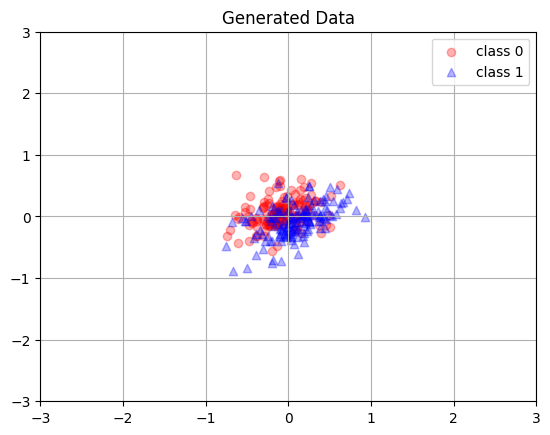

In [21]:
draw_data(generated[labels==0].cpu(), generated[labels==1].cpu(), title_str='Generated Data')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)

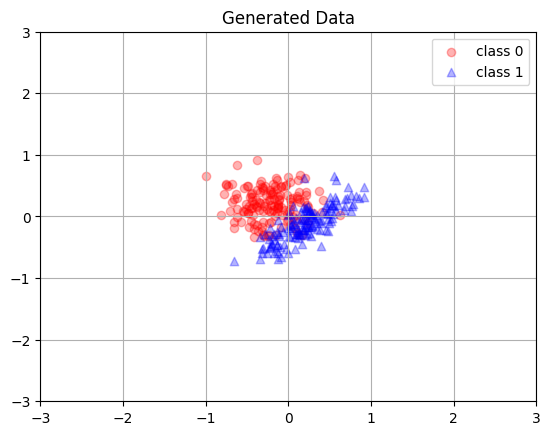

In [22]:
w_val = 1.
n_gen = 300
labels = torch.cat([torch.zeros(int(n_gen/2)), torch.ones(int(n_gen/2))])
generated = generate_new_data_cfg(
        best_model, n_gen, labels,
        n_classes=n_classes,
        device=device,
        gif_name="synthetic_2d_cfg.gif", w_val=w_val
    )

draw_data(generated[labels==0].cpu(), generated[labels==1].cpu(), title_str='Generated Data')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)

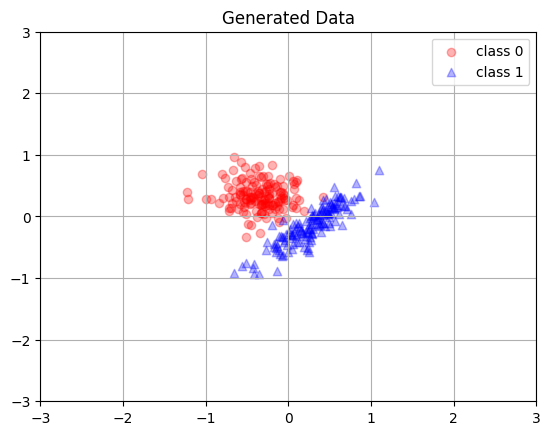

In [23]:
w_val = 2.
n_gen = 300
labels = torch.cat([torch.zeros(int(n_gen/2)), torch.ones(int(n_gen/2))])
generated = generate_new_data_cfg(
        best_model, n_gen, labels,
        n_classes=n_classes,
        device=device,
        gif_name="synthetic_2d_cfg.gif", w_val=w_val
    )

draw_data(generated[labels==0].cpu(), generated[labels==1].cpu(), title_str='Generated Data')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)